# Hintakehitys

Tässä dokumentissa on lähinnä piirretty erilaisia hinnan kuvaajia. Data esikäsitellään projektia varten ohjelmoidulla esikäsittelijällä, joka otetaan käyttöön moduulina.

Kuvaajissa asennukset on jaettu kolmeen ryhmään. Ensimmäisessä ryhmässä on asuinkohteiden asennukset, toisessa pienet (korkeintaan 100 kW) ei-asuinkohteiden järjestelmät ja kolmannessa suuret (yli 100 kW) ei-asuinkohteiden järjestelmät.

Lisäksi esikäsittelijä selvittää järjestelmät, joissa todennäköisesti on akku. Tätä ominaisuutta hyödyntäen tehdään erilliset kuvaajat järjestelmien hinnoista akulla ja ilman.

## Käytetyt kirjastot ja datan lataus

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import importlib.util
import sys

try:
  import preprocessor as esik
except ModuleNotFoundError:
  file_path = "./preprocessor.py"; module_name = "preprocessor"; spec = importlib.util.spec_from_file_location(module_name, file_path)
  esik = importlib.util.module_from_spec(spec); sys.modules[module_name] = esik; spec.loader.exec_module(esik)


price_col = 'price_per_W'
customer_segment = 'customer_segment_3'

cols = ['year', 'battery_storage', price_col, customer_segment]

df_all = esik.esik(cols, no_tpo_prices=False)


## Stand alone PV hintakehitys

Piirretään hintakehitys akuttomille aurinkopaneelijärjestelmille.

### Residential eli asuinkohteet

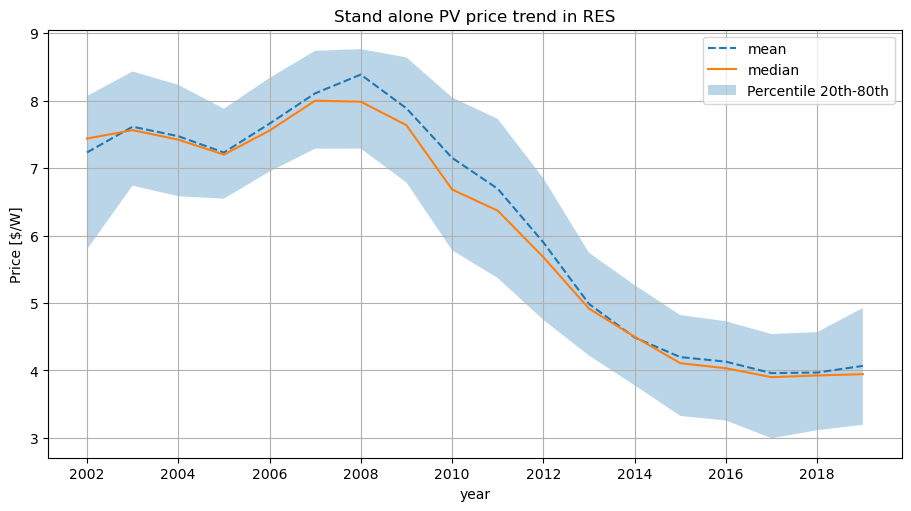

In [2]:
df = df_all.copy()
df = df[(df['battery_storage'] == 0)]
df.dropna(subset=[price_col], inplace=True)

year_stats = df.groupby([customer_segment, 'year'])

q_width = 0.6
q_high = 0.5 + q_width * 0.5
q_low = 0.5 - q_width * 0.5
trend_median = year_stats[price_col].median()
trend_mean = year_stats[price_col].mean()
trend_q_high = year_stats[price_col].quantile(q_high)
trend_q_low = year_stats[price_col].quantile(q_low)

# Päivämäärän pyöristys kuvaajaan
locator = mdates.AutoDateLocator(minticks=8)

def format_date(x1, pos=None):
    thisind = np.clip(int(x1 + 0.5), 0, N - 1)
    return x[thisind]


# Määritetään x-akselin arvot eli tarkistetaan miltä vuosilta on dataa.
seg = 'RES'
x = trend_mean[seg].index
N = len(x)
ind = np.arange(N)

# Piirto
fig, ax = plt.subplots(1, 1, layout="constrained", figsize=(9,5))
ax.plot(ind, trend_mean[seg], label='mean', linestyle='--')
ax.plot(ind, trend_median[seg], label='median')
ax.fill_between(ind, trend_q_low[seg], trend_q_high[seg], alpha=0.3, label=f'Percentile {str(int(100*q_low))}th-{str(int(100*q_high))}th')
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(format_date)
ax.set_xlabel('year')
ax.set_ylabel('Price [$/W]')
ax.set_title(f"Stand alone PV price trend in {seg}")
ax.legend()
ax.grid()
plt.show()


### Small non-residential eli pienet ei-asuinkohteet

Järjestelmä on pieni, jos teho on pienempi tai yhtä suuri kuin 100 kW.

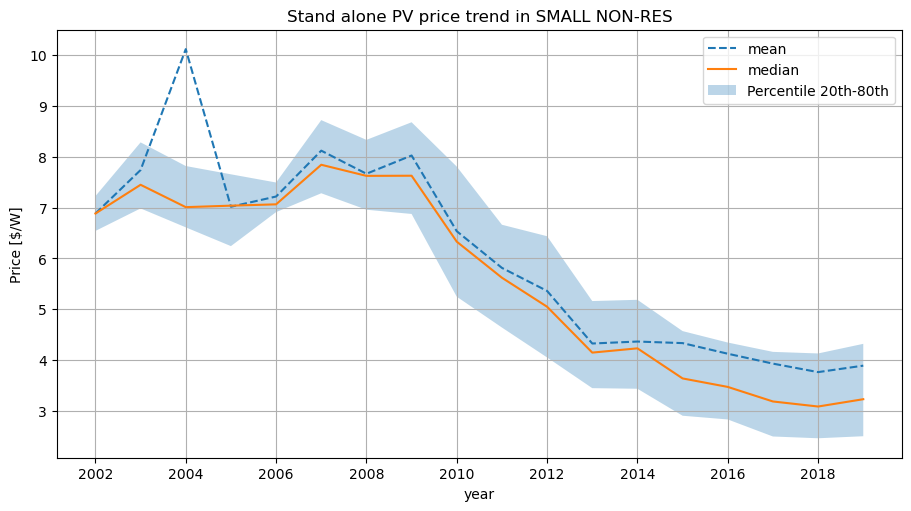

In [3]:
seg = 'SMALL NON-RES'
# Määritetään x-akselin arvot eli tarkistetaan miltä vuosilta on dataa.
x = trend_mean[seg].index
N = len(x)
ind = np.arange(N)

fig, ax = plt.subplots(1, 1, layout="constrained", figsize=(9,5))
ax.plot(ind, trend_mean[seg], label='mean', linestyle='--')
ax.plot(ind, trend_median[seg], label='median')
ax.fill_between(ind, trend_q_low[seg], trend_q_high[seg], alpha=0.3, label=f'Percentile {str(int(100*q_low))}th-{str(int(100*q_high))}th')
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(format_date)
ax.set_xlabel('year')
ax.set_ylabel('Price [$/W]')
ax.set_title(f"Stand alone PV price trend in {seg}")
ax.legend()
ax.grid()
plt.show()


### Large non-residential eli suuret ei-asuinkohteet

Järjestelmä on suuri, jos teho on suurempi kuin 100 kW.

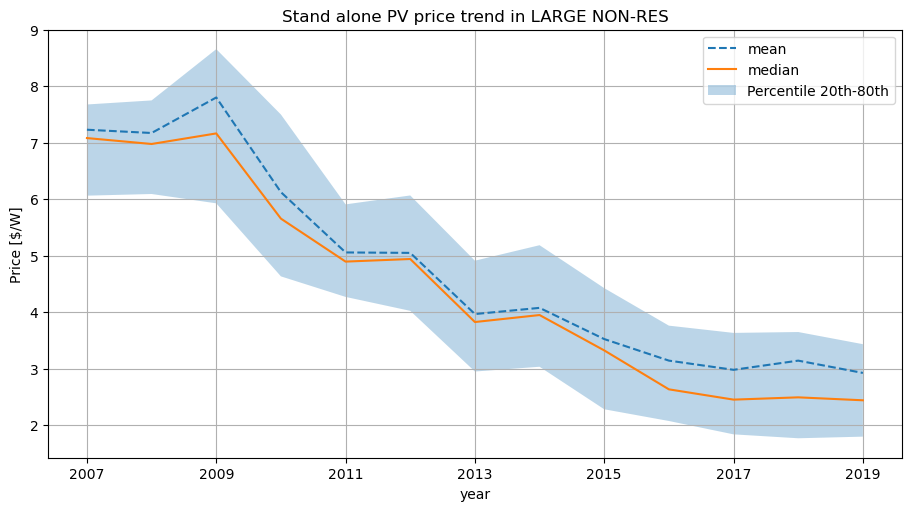

In [4]:
seg = 'LARGE NON-RES'
# Määritetään x-akselin arvot eli tarkistetaan miltä vuosilta on dataa.
x = trend_mean[seg].index
N = len(x)
ind = np.arange(N)

fig, ax = plt.subplots(1, 1, layout="constrained", figsize=(9,5))
ax.plot(ind, trend_mean[seg], label='mean', linestyle='--')
ax.plot(ind, trend_median[seg], label='median')
ax.fill_between(ind, trend_q_low[seg], trend_q_high[seg], alpha=0.3, label=f'Percentile {str(int(100*q_low))}th-{str(int(100*q_high))}th')
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(format_date)
ax.set_xlabel('year')
ax.set_ylabel('Price [$/W]')
ax.set_title(f"Stand alone PV price trend in {seg}")
ax.legend()
ax.grid()
plt.show()


## Paired PV and storage hintakehitys

Piirretään hintakehitys akullisille aurinkopaneelijärjestelmille. Kuvaajat näyttävät selvästi poikkeavan edellä olevista kuvaajista, joten niihin kannattaa suhtautua varauksellisesti. Ilmeisesti menetelmä erotella akkujärjestelmät ei ollut kovin toimiva tai sitten Tesla Energyn asennusten hinnoittelu määrittää hintoja suurimmaksi osaksi, jolloin on mahdollista, että hintojen vaihtelu vähenee kuvien osoittamalla tavalla.

### Residential eli asuinkohteet

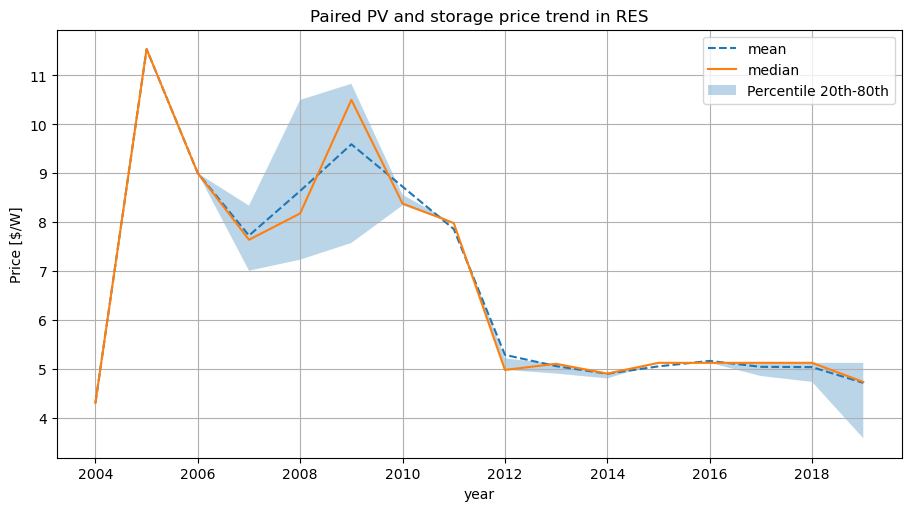

In [5]:
df = df_all.copy()
df = df[(df['battery_storage'] == 1)]
df.dropna(subset=[price_col], inplace=True)

year_stats = df.groupby([customer_segment, 'year'])

q_width = 0.6
q_high = 0.5 + q_width * 0.5
q_low = 0.5 - q_width * 0.5
trend_median = year_stats[price_col].median()
trend_mean = year_stats[price_col].mean()
trend_q_high = year_stats[price_col].quantile(q_high)
trend_q_low = year_stats[price_col].quantile(q_low)

# Päivämäärän pyöristys kuvaajaan
locator = mdates.AutoDateLocator(minticks=8)

def format_date(x1, pos=None):
    thisind = np.clip(int(x1 + 0.5), 0, N - 1)
    return x[thisind]


# Määritetään x-akselin arvot eli tarkistetaan miltä vuosilta on dataa.
seg = 'RES'
x = trend_mean[seg].index
N = len(x)
ind = np.arange(N)

# Piirto
fig, ax = plt.subplots(1, 1, layout="constrained", figsize=(9,5))
ax.plot(ind, trend_mean[seg], label='mean', linestyle='--')
ax.plot(ind, trend_median[seg], label='median')
ax.fill_between(ind, trend_q_low[seg], trend_q_high[seg], alpha=0.3, label=f'Percentile {str(int(100*q_low))}th-{str(int(100*q_high))}th')
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(format_date)
ax.set_xlabel('year')
ax.set_ylabel('Price [$/W]')
ax.set_title(f"Paired PV and storage price trend in {seg}")
ax.legend()
ax.grid()
plt.show()


### Small non-residential eli pienet ei-asuinkohteet

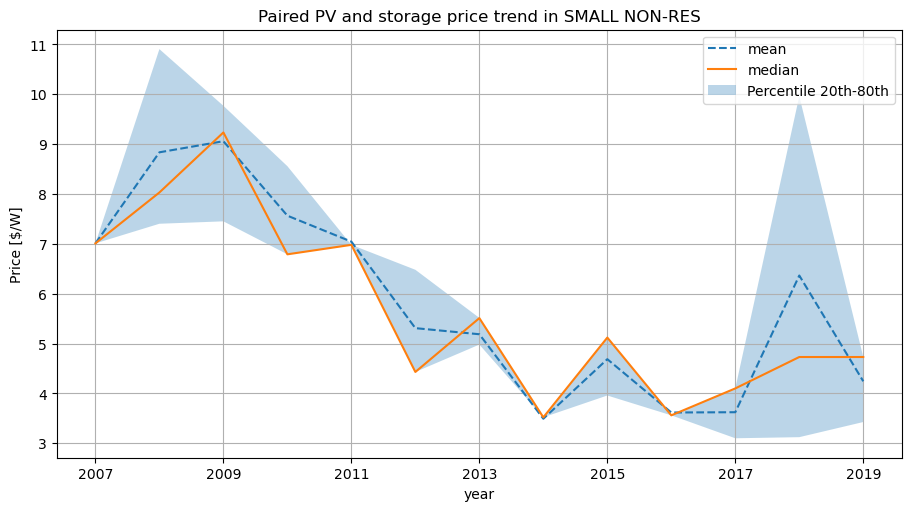

In [6]:
seg = 'SMALL NON-RES'
# Määritetään x-akselin arvot eli tarkistetaan miltä vuosilta on dataa.
x = trend_mean[seg].index
N = len(x)
ind = np.arange(N)

fig, ax = plt.subplots(1, 1, layout="constrained", figsize=(9,5))
ax.plot(ind, trend_mean[seg], label='mean', linestyle='--')
ax.plot(ind, trend_median[seg], label='median')
ax.fill_between(ind, trend_q_low[seg], trend_q_high[seg], alpha=0.3, label=f'Percentile {str(int(100*q_low))}th-{str(int(100*q_high))}th')
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(format_date)
ax.set_xlabel('year')
ax.set_ylabel('Price [$/W]')
ax.set_title(f"Paired PV and storage price trend in {seg}")
ax.legend()
ax.grid()
plt.show()


### Large non-residential eli suuret ei-asuinkohteet

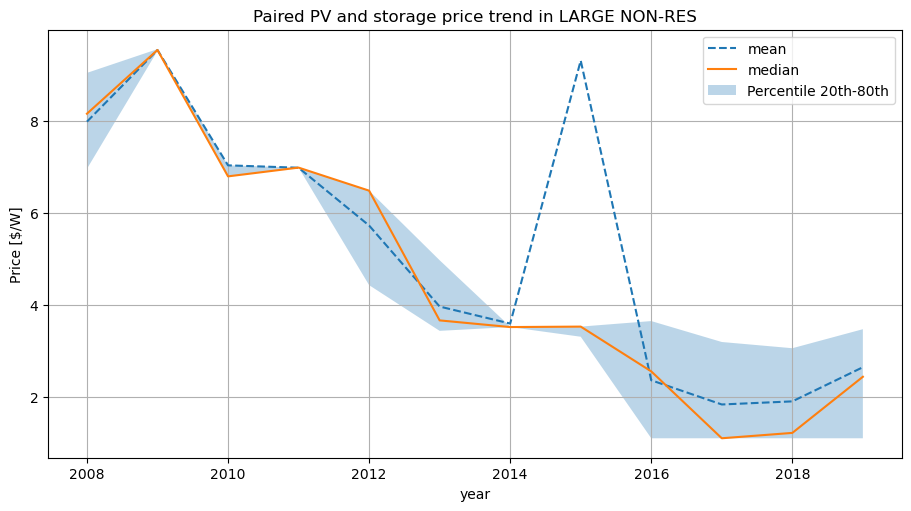

In [7]:
seg = 'LARGE NON-RES'
# Määritetään x-akselin arvot eli tarkistetaan miltä vuosilta on dataa.
x = trend_mean[seg].index
N = len(x)
ind = np.arange(N)

fig, ax = plt.subplots(1, 1, layout="constrained", figsize=(9,5))
ax.plot(ind, trend_mean[seg], label='mean', linestyle='--')
ax.plot(ind, trend_median[seg], label='median')
ax.fill_between(ind, trend_q_low[seg], trend_q_high[seg], alpha=0.3, label=f'Percentile {str(int(100*q_low))}th-{str(int(100*q_high))}th')
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(format_date)
ax.set_xlabel('year')
ax.set_ylabel('Price [$/W]')
ax.set_title(f"Paired PV and storage price trend in {seg}")
ax.legend()
ax.grid()
plt.show()
